# 毕业项目：为 Arvato Financial Services 金融服务公司实现一个顾客分类报告

该项目要求你分析德国的一家邮购公司的顾客的人口统计数据，将它和一般的人口统计数据进行比较。你将使用非监督学习技术来实现顾客分类，识别出哪些人群是这家公司的基础核心用户。之后，你将把所学的知识应用到第三个数据集上，该数据集是该公司的一场邮购活动的营销对象的人口统计数据。用你搭建的模型预测哪些人更可能成为该公司的顾客。你要使用的数据由我们的合作伙伴 Bertelsmann Arvato Analytics 公司提供。这是真实场景下的数据科学任务。

如果你完成了这个纳米学位的第一学期，做过其中的非监督学习项目，那么你应该对这个项目的第一部分很熟悉了。两个数据集版本不同。这个项目中用到的数据集会包括更多的特征，而且没有预先清洗过。你也可以自由选取分析数据的方法，而不用按照既定的步骤。如果你选择完成的是这个项目，请仔细记录你的步骤和决策，因为你主要交付的成果就是一篇博客文章报告你的发现。

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
workspace_path = {'windows': 'C:/Data/data/', 
                  'udactity': '../../data/Term2/capstone/arvato_data/'}
drive_path = workspace_path['windows']

## 第 0 部分：了解数据

项目数据中包括四个数据文件

- `Udacity_AZDIAS_052018.csv`: 德国的一般人口统计数据；891211 人（行）x 366 个特征（列）
- `Udacity_CUSTOMERS_052018.csv`: 邮购公司顾客的人口统计数据；191652 人（行）x 369 个特征（列）
- `Udacity_MAILOUT_052018_TRAIN.csv`: 营销活动的对象的人口统计数据；42982 人（行）x 367 个特征（列）
- `Udacity_MAILOUT_052018_TEST.csv`: 营销活动的对象的人口统计数据；42833 人（行）x 366个特征（列）

人口统计数据的每一行表示是一个单独的人，也包括一些非个人特征，比如他的家庭信息、住房信息以及周边环境信息。使用前两个数据文件中的信息来发现顾客（"CUSTOMERS"）和一般人（"AZDIAS"）在何种程度上相同和不同，然后根据你的分析对其余两个数据文件（"MAILOUT"）进行预测，预测更可能成为该邮购公司的客户。

"CUSTOMERS" 文件包括三个额外的列（'CUSTOMER_GROUP'、’'ONLINE_PURCHASE' 和 'PRODUCT_GROUP'），提供了文件中顾客的更多维度的信息。原始的 "MAILOUT" 包括一个额外的列 "RESPONSE"，表示每个收到邮件的人是否成为了公司的顾客。对于 "TRAIN" 子数据集，该列被保留，但是在 "TEST" 子数据集中该列被删除了，它和你最后要在 Kaggle 比赛上预测的数据集中保留的列是对应的。

三个数据文件中其他的所有列都是相同的。要获得关于文件中列的更多信息，你可以参考 Workspace 中的两个 Excel 电子表格。[其一](./DIAS Information Levels - Attributes 2017.xlsx) 是一个所有属性和描述的列表，按照信息的类别进行排列。[其二](./DIAS Attributes - Values 2017.xlsx) 是一个详细的每个特征的数据值对应关系，按照字母顺序进行排列。

在下面的单元格中，我们提供了一些简单的代码，用于加载进前两个数据集。注意，这个项目中所有的 `.csv` 数据文件都是分号(`;`) 分割的，所以 [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) 中需要加入额外的参数以正确地读取数据。而且，考虑数据集的大小，加载整个数据集可能会花费一些时间。


你会注意到在数据加载的时候，会弹出一个警告（warning）信息。在你开始建模和分析之前，你需要先清洗一下数据。浏览一下数据集的结构，查看电子表格中信息了解数据的取值。决定一下要挑选哪些特征，要舍弃哪些特征，以及是否有些数据格式需要修订。我们建议创建一个做预处理的函数，因为你需要在使用数据训练模型前清洗所有数据集。

In [ ]:
%%time
azdias = pd.read_csv(drive_path + 'Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv(drive_path + 'Udacity_CUSTOMERS_052018.csv', sep=';')

# use column LNR as index
azdias.set_index('LNR', inplace=True)
customers.set_index('LNR', inplace=True)

print('azdias has shape:', azdias.shape, '. customers has shape:', customers.shape)

In [ ]:
azdias.head()

In [ ]:
customers.head()

## 第0部分：清洗数据 cleaning Data


### 警告形象对应的数据问题

首先我们看看警告所提出的问题，18和19列里到底有什么样的数据问题？

In [ ]:
print('column 18 label is', azdias.columns[18])
print('column 19 label is', azdias.columns[19])
print(azdias[azdias.columns[18]].unique())
print(azdias[azdias.columns[19]].unique())

In [ ]:
def findObjectAttributs(dataframe):
  '''
  find which column in dataframe has object as dtype. 
  Args:
    dataframe {DataFrame} -- it could be customer or azdias
  Returns:
    {set} -- a set of column names, those the dtypes of column is value type 
      object
  '''
  for attr in dataframe.columns[1:]: 
    attr_unique_values = dataframe[attr].unique()
    if dataframe[attr].dtypes == "object": 
      print(f'{attr} has value {attr_unique_values}')

print('== findObjectAttributs(azdias) ==')
findObjectAttributs(azdias)

print('== findObjectAttributs(customers) ==')
findObjectAttributs(customers)


居于上面的方向我们发现了这里有 X 和 XX 的数据，对应于数据描述./DIAS Attributes - Values 2017.xlsx这些并不市有效的值。同时还存在string和number共同存在这些列中。我们将先对这两列作相应的处理。同时我们发现作为需要的值是可以处理为-1，表示unknown。

In [ ]:
def cleanupCameoDeu2015(dataframe):
  '''
  The columns CAMEO_DEU_2015 and CAMEO_INTL_2015 contains string, float as mix value column. There is also XX or X as invalid values,
  we will clean them. 
  Args: 
    dataframe -- {DataFrame} it could be azdias or customers
  Returns:
    None  
  '''
  dataframe['CAMEO_DEU_2015'] = dataframe['CAMEO_DEU_2015'].replace('XX', np.nan)
  print(f'after cleanup column CAMEO_DEU_2015 has values: {dataframe["CAMEO_DEU_2015"].unique()}\n')

  dataframe['CAMEO_DEUG_2015'] = dataframe['CAMEO_DEUG_2015']\
                                  .replace('X', np.nan)\
                                  .map(lambda x: str(x)[0])\
                                  .map(lambda x: np.nan if x in ['n'] else x)
  print(f'after cleanup column CAMEO_DEUG_2015 has values: {dataframe["CAMEO_DEUG_2015"].unique()}\n')

  dataframe['CAMEO_INTL_2015'] = dataframe['CAMEO_INTL_2015']\
                              .replace('XX', np.nan)\
                              .map(lambda x: str(x)[0:1] if str(x)[-2:]=='.0' else x)\
                              .map(lambda y: np.nan if y == 'na' else y)
  print(f'after cleanup column CAMEO_INTL_2015 has values: {dataframe["CAMEO_INTL_2015"].unique()}\n')


print("== cleanupCameoDeu2015 in azdias ==")
cleanupCameoDeu2015(azdias)

print("== cleanupCameoDeu2015 in customers ==")
cleanupCameoDeu2015(customers)

### 读取Attributes和Values的描述 

Arvato 提供了对应的Meta数据集，Attributes是所有像个的描述。Values包含了每个Attribute可能的数据值，以及其对应的意义Meaning。这里我们把他读取出来，整理成一些相应需要的变量，为后面的数据清洗做准备。特别是Unknown数据，我们可以利用描述来找到对应的值，准备好清洗掉它们。

In [ ]:
# load from xlsx files
attribute_info_df = pd.read_excel(drive_path + 'DIAS Information Levels - Attributes 2017.xlsx', index_col=None, header=1)
attribute_values_df = pd.read_excel(drive_path + 'DIAS Attributes - Values 2017.xlsx', index_col=None, header=1)

# delte empty cell
del attribute_info_df['Unnamed: 0']
del attribute_values_df['Unnamed: 0']

attribute_values_df = attribute_values_df.fillna(method='ffill', axis=0) # fill merged-cell with first value in above
print('attribute_info_df has shape:', attribute_info_df.shape, '. attribute_values_df has shape', attribute_values_df.shape)

In [ ]:
attribute_info_df.head()

In [ ]:
attribute_values_df.head()

In [ ]:
# display all possilbe meaning has 'unknown'
meaning_se = pd.Series(attribute_values_df['Meaning'].unique())
meaning_se[meaning_se.str.contains('known', flags=re.IGNORECASE, regex=True)]

In [ ]:
def getUnknownValues(attribute_values):
  ''' 
  calculate the column names of the with meaning 'unknown' or simular meaning.
  the unknown value -1, we will do general replace, so we do ignore it.

  Args:
    attribute_values -- {DataFrame} the attribute values from "DIAS Attributes - Values 2017.xlsx"
  Returns:
    {set} of all possible attirbute columns. eg. "D19_VERSI_ANZ_12__0" 
  '''
  unknown = ['unknown', 
            'unknown / no main age detectable',
            'no transactions known',
            'no transaction known']

  attribute_unknown = attribute_values[attribute_values['Meaning'].isin(unknown)]
  attribute_unknown['Value'].astype(str).map(lambda st: st.split(', '))
  unknown_columns = dict()

  for index, row in attribute_unknown.iterrows():
    attribute_name = row['Attribute'].replace('_RZ', '')
    attribute_values = str(row['Value']).split(', ')
    for unknown_val in attribute_values:
      if unknown_val == '-1':
        continue
      #unknown_columns.add(f'{attribute_name}__{unknown_val}')
      unknown_columns[attribute_name] = unknown_val
  return unknown_columns


In [ ]:
columnUnknowValues = getUnknownValues(attribute_values_df)
print('following dict contains column and it unknown values', columnUnknowValues)

In [ ]:
def cleanupUnknownValue(dataframe, columnUnknowValuesDict):
    '''
    all unknown meaning values in dataframe will be set as NaN. 
    Args: 
        dataframe -- {DataFrame}
        columnUnknowValuesDict -- {dictionary}
    Returns:
        None 
    '''    
    for (key, value) in columnUnknowValuesDict.items():
        if key in dataframe.columns:
            dataframe[key].replace(value, np.nan, inplace=True)
        else:
            print(f'Can not find {key} column，just skip')

In [ ]:
cleanupUnknownValue(azdias, columnUnknowValues)
azdias

In [ ]:
cleanupUnknownValue(customers, columnUnknowValues)
customers

attributes 和 values定义和实际数据中使用的差距

In [ ]:
azdias_attributes = azdias.columns
customer_attributes = customers.columns
attributes_in_valuesDf = attribute_values_df['Attribute'].unique()
attributes_in_attributesDf = attribute_info_df['Attribute'].unique()

print(f'there are {azdias_attributes.size} in azdias')
print(f'there are {customer_attributes.size} in customers')
print(f'there are {attributes_in_valuesDf.shape[0]} in attribute_values_df')
print(f'there are {attributes_in_attributesDf.shape[0]} in attribute_info_df')

为什么在azdias和customer的特征列数量和描述数据values和attributs不对应呢？这里我们进一步通过显示数据来做分析。

In [ ]:
attributes_without_meta = set()
ind = 0
for attr in azdias_attributes:
  ind += 1
  if attr not in attributes_in_valuesDf:
    attributes_without_meta.add(attr)
    print(f'Attribute No.{ind} {attr} is not in "DIAS Attributes - Values 2017.xlsx", but in azdias values are: {azdias[attr].unique()}')

通过观察我们发现，D19_LETZTER_KAUF_BRANCHE的值刚好对应了其他D19的列，数据看上去有一定的重复。CJT_KATALOGNUTZER也是类似情况，被其他CJT列所重复。ANZ_STATISTISCHE_HAUSHALTE，EXTSEL992有大量的数值，但是我们这里缺乏具体的meta数据，这里我们决定不再保留。EINGEZOGENAM_HH_JAHR。GEBURTSJAHR是出身年份，我们还有其他的列含有相关年龄的列ALTER_HH所以我们也决定忽略。

In [ ]:
def detec_many_nan_attributes(dataframe, limitation = 0.9): 
    '''
    find attribute in dataframe with over 90% NaN value.
    '''       
    nan_counts = pd.Series(dataframe.isnull().sum())
    line_count = dataframe.shape[0]
    too_many_nan_attributes = []
    for idx, col in nan_counts.items():
        if col/line_count > limitation:
            too_many_nan_attributes.append(idx)

    return too_many_nan_attributes

print(detec_many_nan_attributes(customers), 'in customers has over 90% NaN')
print(detec_many_nan_attributes(azdias), 'in azdias has over 90% NaN')

In [ ]:
azdias_shapeBefore = azdias.shape[1]
customers_shapeBefore = customers.shape[1]
columns_to_drop = {'D19_LETZTER_KAUF_BRANCHE', 
                   'CJT_KATALOGNUTZER', 
                   'EINGEZOGENAM_HH_JAHR', 
                   'ANZ_STATISTISCHE_HAUSHALTE',
                   'ANZ_HAUSHALTE_AKTIV'
                   'VERDICHTUNGSRAUM', 
                   'EXTSEL992',
                   'GEBURTSJAHR',
                   'ALTER_KIND1',
                   'ALTER_KIND2',
                   'ALTER_KIND3',
                   'ALTER_KIND4'}

azdias.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)
customers.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)

columns_to_drop.clear()

print(f'before azdias drop {azdias_shapeBefore}, and after {azdias.shape}')
print(f'before customers drop {customers_shapeBefore}, and customers {customers.shape}')

In [ ]:
# extract special columns from customers
customer_special_columns = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customer_special_df = customers[customer_special_columns]

print(f'columns {customer_special_columns} will be delete from customers')
customers.drop(columns=customer_special_columns, axis=1, errors='ignore', inplace=True)

customer_special_df.head()
print(f'customer columns size is {len(customers.columns)}, azdias columns size is {len(azdias.columns)}')

EINGEFUEGT_AM是数据添加的时间，一共有5163个时间点，我们只采纳的年份作为特这。将其替换为EINGEFUEGT_AM将会只是数据输入的年份。

In [ ]:
def pickYearValue(dataframe, attributeName):
  '''
  use only the year of timestamp as value for the attribute
  Args:
    dataframe {DataFrame} -- customers or azdias
    attributeName {string} -- attribute name, which hast timestamp value 
      like 1992-02-10 00:00:00
  Returns:
    None
  '''
  attr_values = dataframe[attributeName].unique()
  print(f'Attribute {attributeName} has {attr_values.shape[0]} values')
  print('Before change:\n', dataframe[attributeName].head())
  dataframe[attributeName] = dataframe[attributeName]\
                            .map(lambda x: str(x)[:4] if x != np.nan else x)\
                            .map(lambda x: np.nan if x=='nan' else x)
  print(f'After change:\n', dataframe[attributeName].head())
  print('We replaced dataframe[attributeName] with only the year values:',
        dataframe[attributeName].unique())


print("== pickYearValue(customers, 'EINGEFUEGT_AM') ==")
pickYearValue(customers, 'EINGEFUEGT_AM')

print("== pickYearValue(azdias, 'EINGEFUEGT_AM') ==")
pickYearValue(azdias, 'EINGEFUEGT_AM')

#### 在FEIN和GROB数据中做选择

在属性描述中我们看到，有不少属性我们同时拥有细化（FEIN）和粗略（GROB）的数据特征。这里在试验初期我们决定采用细化（FEIN）的特征。

In [ ]:
for attr in attributes_in_attributesDf:
  if attr.endswith('_GROB'):
    columns_to_drop.add(attr)

print(f'== delete {columns_to_drop} from azdias ==')
azdias.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)

print(f'== delete {columns_to_drop} from customers ==')
customers.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)
columns_to_drop.clear()

后面我们不再需要的数据，我们从内存中清除。

In [ ]:
# del dataframes
del attribute_values_df
del attribute_info_df

In [ ]:
def detec_attributes_has_many_values(dataframe, valueSizeLimit = 30):
  '''
  find attributes/columns in dataframe, they have an oversize of the values. 

  Args:
    dataframe {DataFrame} -- it could be customers and azdias
    valueSizeLimit {int} -- the limitation of value size you want to check, 
      default 10
  Returns:
    {set} -- all attributs, in dataframe has more than 10 values
  '''
  value_oversize_columns = set()
  for (columnName, columnData) in dataframe.iteritems():
    attr_unique_values = columnData.unique()
    if attr_unique_values.size >= valueSizeLimit: 
      value_oversize_columns.add(columnName)
      print(f'{columnName} has value {attr_unique_values}')
  #return value_oversize_columns

print('== detec_attributes_has_many_values(azdias) ==')
detec_attributes_has_many_values(azdias)

print('== detec_attributes_has_many_values(customers) ==')
detec_attributes_has_many_values(customers)

In [ ]:
azdias.head()

In [ ]:
customers.head()

In [ ]:
def unifiedValues(dataFrame):
    '''
    unified all numeric columns to a same type
    Args: 
        dataFrame -- {DataFrame}
    Returns: 
        None
    '''
    colDtypes = set()
    dataFrame.fillna(-1, inplace=True)
    for (colIndex, colData) in dataFrame.iteritems():
        colDtypes.add(colData.dtype)
        if colData.dtype in ['float64', 'int64']:
            dataFrame[colIndex].fillna(-1, inplace=True)
            dataFrame[colIndex] = pd.to_numeric(dataFrame[colIndex], downcast='signed').astype(int)

    print('Before unified we have columns in ', colDtypes)

    colDtypes.clear()
    for (colIndex, colData) in dataFrame.iteritems():
        colDtypes.add(colData.dtype)
    print('After unified we have columns in', colDtypes)


In [ ]:
%%time
unifiedValues(customers)

In [ ]:
%%time
unifiedValues(azdias)

In [ ]:
customers.info()

In [ ]:
azdias.info()

In [ ]:
customers.to_pickle("unified_customers.pkl")
print('unified customers data saved as unified_customers.pkl')

azdias.to_pickle("unified_azdias.pkl")
print('unified azdias data saved as unified_azdias.pkl')

## 清理过的数据获取特征矩阵

经过清洗后的数据是以LNR作为index，列为我们保留的所有Attributes。每列的Value还是经过统一处理后的对应DIAS Attributes - Values 2017.xlsx中定义的有效整型值和NaN。

In [3]:
print('we can load cleaned customer data from unified_customers.pkl')
customers = pd.read_pickle('unified_customers.pkl')

print('we can load cleaned azdias data from unified_azdias.pkl')
azdias = pd.read_pickle("unified_azdias.pkl")

we can load cleaned customer data from unified_customers.pkl
we can load cleaned azdias data from unified_azdias.pkl


In [4]:
# add lable 'IS_CUSTOMER' to data
azdias['IS_CUSTOMER'] = 0
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,IS_CUSTOMER
LNR,,,,,,,,,,,,,,,,,,,,,
910215,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,3,1,0
910220,-1,9,0,21,11,0,0,2,0,3,...,4,8,11,10,3,9,4,5,2,0
910225,-1,9,17,17,10,0,0,1,0,3,...,2,9,9,6,3,9,2,5,2,0
910226,2,1,13,13,1,0,0,0,0,2,...,0,7,10,11,-1,9,7,3,2,0
910241,-1,1,20,14,3,0,0,4,0,4,...,2,3,5,4,2,9,3,4,1,0


In [5]:
customers['IS_CUSTOMER'] = 1
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,IS_CUSTOMER
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2,1,10,10,1,0,0,2,0,1,...,3,5,3,2,6,9,7,3,1,1
9628,-1,9,11,-1,-1,-1,0,3,0,-1,...,-1,6,6,3,0,9,-1,3,1,1
143872,-1,1,6,0,1,0,0,1,0,3,...,4,10,13,11,6,9,2,3,2,1
143873,1,1,8,8,0,-1,0,0,0,1,...,2,6,4,2,-1,9,7,1,1,1
143874,-1,1,20,14,7,0,0,4,0,3,...,4,3,5,4,2,9,3,1,1,1


In [6]:
print('azdias.shape=', azdias.shape, 'customers.shape=',customers.shape)

azdias.shape= (891221, 352) customers.shape= (191652, 352)


In [91]:
def plot_attribute_value_proprtion(dataframe, column_name, p):
    plt.subplot(1, 2, p)
    max_count = dataframe[column_name].value_counts().max()
    n_points = customers.shape[0]
    max_prop = max_count / n_points

    # generate tick mark locations and names
    tick_props = np.arange(0, max_prop, 0.1)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    sns.countplot(data=dataframe, x=column_name,  color = sns.color_palette()[0])
    plt.yticks(tick_props * n_points, tick_names)
    plt.ylabel('proportion')

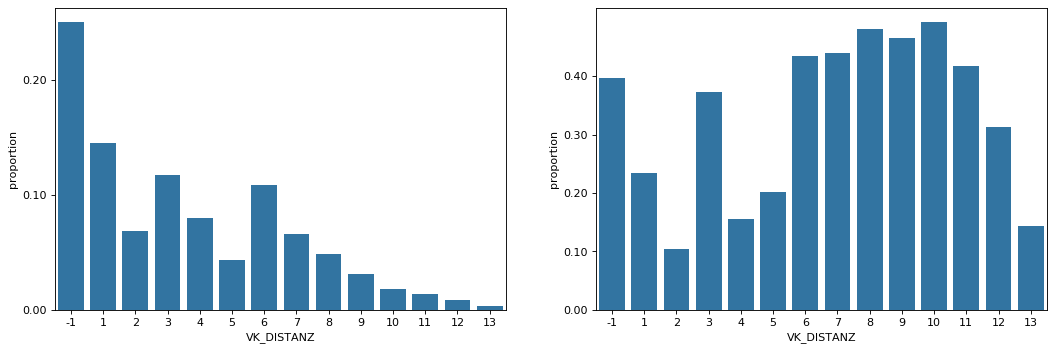

In [92]:
fig=plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
plot_attribute_value_proprtion(customers, 'VK_DISTANZ', 1)
plot_attribute_value_proprtion(azdias, 'VK_DISTANZ', 2)

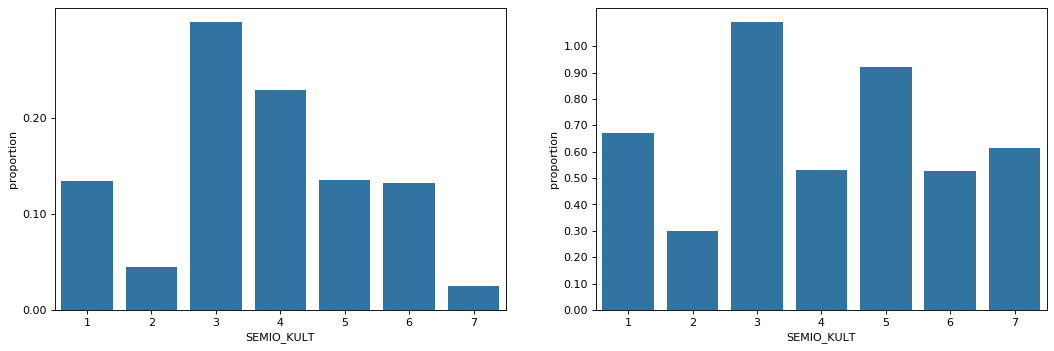

In [94]:
fig=plt.figure(figsize=(16, 5), dpi= 80, facecolor='w', edgecolor='k')
plot_attribute_value_proprtion(customers, 'SEMIO_KULT', 1)
plot_attribute_value_proprtion(azdias, 'SEMIO_KULT', 2)

因为我们看到azdias和customers具有相同的列，我们将这两个数据集整合在一起

In [95]:
all_data = azdias.append(customers)
all_data.to_pickle('unified_all_data.pkl')

In [97]:
all_data.shape

(1082873, 352)

Text(0, 0.5, 'WOHNLAGE')

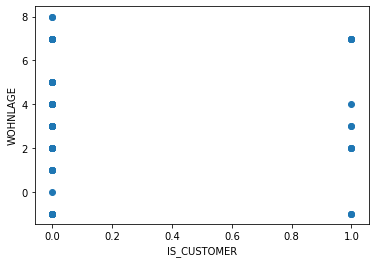

In [99]:
plt.scatter(data=all_data.sample(100), x='IS_CUSTOMER', y='WOHNLAGE')
plt.xlabel('IS_CUSTOMER')
plt.ylabel('WOHNLAGE')

In [101]:
import os
def convertToDummiesAndSave(dataframe, filename):
    data = dataframe.astype(str).replace('-1', np.nan)
    dummies = pd.get_dummies(data, prefix_sep='__', sparse=True)
    print(f'get_dummies result will be saved in {filename}.')

    if os.path.exists(filename):
        print(f'{filename} is already exist, will be deleted then save')
        os.remove(filename)
    
    dummies.to_pickle(filename)

    return dummies

In [100]:
%%time
# this takes long
customers_df = convertToDummiesAndSave(customers, 'customers_dummies.pkl')

NameError: name 'convertToDummiesAndSave' is not defined

In [ ]:
%%time
# this takes long
azdias_df = convertToDummiesAndSave(azdias, 'azdias_dummies.pkl')

In [ ]:
%%time
# this takes long
all_data_df = convertToDummiesAndSave(all_data, 'all_data_dummies.pkl')
print(all_data_df.shape)
all_data.head()

## 第1部分：顾客分类报告

项目报告的主体部分应该就是这部分。在这个部分，你应该使用非监督学习技术来刻画公司已有顾客和德国一般人群的人口统计数据的关系。这部分做完后，你应该能够描述一般人群中的哪一类人更可能是邮购公司的主要核心顾客，哪些人则很可能不是。

In [117]:
all_data_df = pd.read_pickle('all_data_dummies.pkl')
all_data_df.head()

,AGER_TYP__0,AGER_TYP__1,AGER_TYP__2,AGER_TYP__3,AKT_DAT_KL__1,AKT_DAT_KL__2,AKT_DAT_KL__3,AKT_DAT_KL__4,AKT_DAT_KL__5,AKT_DAT_KL__6,...,ZABEOTYP__1,ZABEOTYP__2,ZABEOTYP__3,ZABEOTYP__4,ZABEOTYP__5,ZABEOTYP__6,ANREDE_KZ__1,ANREDE_KZ__2,IS_CUSTOMER__0,IS_CUSTOMER__1
LNR,,,,,,,,,,,,,,,,,,,,,
910215,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
910220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
910225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
910226,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
910241,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


In [111]:
azdias_df = pd.read_pickle('azdias_dummies.pkl')
azdias_df.drop('IS_CUSTOMER__0', axis=1, inplace=True, errors='ignore')
azdias_df['IS_CUSTOMER'] = 0
azdias_df.head()

,AGER_TYP__0,AGER_TYP__1,AGER_TYP__2,AGER_TYP__3,AKT_DAT_KL__1,AKT_DAT_KL__2,AKT_DAT_KL__3,AKT_DAT_KL__4,AKT_DAT_KL__5,AKT_DAT_KL__6,...,WOHNLAGE__8,ZABEOTYP__1,ZABEOTYP__2,ZABEOTYP__3,ZABEOTYP__4,ZABEOTYP__5,ZABEOTYP__6,ANREDE_KZ__1,ANREDE_KZ__2,IS_CUSTOMER
LNR,,,,,,,,,,,,,,,,,,,,,
910215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
910220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
910225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
910226,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
910241,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [112]:
customers_df = pd.read_pickle('customers_dummies.pkl')
customers_df.drop('IS_CUSTOMER__1',axis=1, inplace=True, errors='ignore')
customers_df['IS_CUSTOMER'] = 1
customers_df.head()

,AGER_TYP__0,AGER_TYP__1,AGER_TYP__2,AGER_TYP__3,AKT_DAT_KL__1,AKT_DAT_KL__2,AKT_DAT_KL__3,AKT_DAT_KL__4,AKT_DAT_KL__5,AKT_DAT_KL__6,...,WOHNLAGE__8,ZABEOTYP__1,ZABEOTYP__2,ZABEOTYP__3,ZABEOTYP__4,ZABEOTYP__5,ZABEOTYP__6,ANREDE_KZ__1,ANREDE_KZ__2,IS_CUSTOMER
LNR,,,,,,,,,,,,,,,,,,,,,
9626,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
9628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
143872,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
143873,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
143874,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


In [114]:
special_columns = set(azdias_df.columns)-set(customers_df.columns)

In [118]:
all_data_df.drop('IS_CUSTOMER__0', axis = 1, inplace = True, errors='ignore')
all_data_df = all_data_df.rename(columns={"IS_CUSTOMER__1": "IS_CUSTOMER"})

In [ ]:
'IS_CUSTOMER' in all_data_df

In [119]:
all_data_df.head()

,AGER_TYP__0,AGER_TYP__1,AGER_TYP__2,AGER_TYP__3,AKT_DAT_KL__1,AKT_DAT_KL__2,AKT_DAT_KL__3,AKT_DAT_KL__4,AKT_DAT_KL__5,AKT_DAT_KL__6,...,WOHNLAGE__8,ZABEOTYP__1,ZABEOTYP__2,ZABEOTYP__3,ZABEOTYP__4,ZABEOTYP__5,ZABEOTYP__6,ANREDE_KZ__1,ANREDE_KZ__2,IS_CUSTOMER
LNR,,,,,,,,,,,,,,,,,,,,,
910215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
910220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
910225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
910226,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
910241,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
azdias_df = pd.read_pickle('azdias_dummies.pkl')
azdias_df.head()

In [ ]:
customers_df = pd.read_pickle('customers_dummies.pkl')
customers_df.head()

In [ ]:
print( azdias_df.info(), customers_df.info(), all_data_df.info() )

In [120]:
selected_features = set(azdias_df.columns).intersection(set(customers_df.columns))
print( f'there are {len(selected_features)} attributes_value intersection between azdias and customers' )

there are 3818 attributes_value differences between azdias and customers


这里我们看到在azdias列的数量大于customers中，这里表示，在azdias中有多余的特征值在customers个完全没有的。我们来具体看看这是也那些特征。这些特征和值市可以刻画azdias与customers明显差异的，我们可以优先选择。

这里我们看到两个特征表中一共有2272不同的特征，这里我们使用这些特征开始做非监督学习。我们首先创建两个单独的DataFrame保留IS_CUSTOMER。

In [ ]:
customers_flag = pd.DataFrame(np.ones_like(customers.index), index=customers.index, columns=['IS_CUSTOMER'])
azdias_flag = pd.DataFrame(np.zeros_like(azdias.index), index=azdias.index, columns=['IS_CUSTOMER'])

all_customer_flag = pd.concat([customers_df, azdias_df])

我们先就单独选取上面的这些Attributes来作第一步实验。先将这些特征列从azdias中提取出来。

In [121]:
all_selected_df = all_data_df[special_columns]
all_selected_df.shape

(1082873, 123)

In [122]:
# Import sklearn's cluster module
from sklearn import cluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score

In [123]:
all_data_df.shape

(1082873, 3944)

In [126]:
selected_features.add('IS_CUSTOMER')



In [127]:
X = all_data_df.drop(selected_features, axis=1, errors='ignore')
X

,ALTER_HH__1,ALTERSKATEGORIE_FEIN__1,ANZ_HAUSHALTE_AKTIV__130,ANZ_HAUSHALTE_AKTIV__132,ANZ_HAUSHALTE_AKTIV__144,ANZ_HAUSHALTE_AKTIV__151,ANZ_HAUSHALTE_AKTIV__152,ANZ_HAUSHALTE_AKTIV__162,ANZ_HAUSHALTE_AKTIV__164,ANZ_HAUSHALTE_AKTIV__166,...,KBA13_ANZAHL_PKW__7,KBA13_ANZAHL_PKW__9,KBA13_AUTOQUOTE__0,KBA13_KRSAQUOT__0,KBA13_KRSHERST_AUDI_VW__0,KBA13_KRSHERST_BMW_BENZ__0,KBA13_KRSHERST_FORD_OPEL__0,KBA13_KRSSEG_KLEIN__0,ORTSGR_KLS9__0,TITEL_KZ__2
LNR,,,,,,,,,,,,,,,,,,,,,
910215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
910220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
910225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
910226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
910241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
%%time
for i in range(2, 6):
    # Try instantiating a model with 2 centers
    kmeans = KMeans(n_clusters=i)  # Then fit the model to your data using the fit mdel_2 = kmeans_2.fit(subset_data)
    cluster = kmeans.fit(X)
    
    print('clusters=', i, 'silhouette_score=', silhouette_score(X, cluster.labels_), 'inertia_=', cluster.inertia_)

clusters= 2 silhouette_score= 0.9994315204944044 inertia_= 856.98862132494
clusters= 3 silhouette_score= 0.9990344389749592 inertia_= 829.6255702529807
clusters= 4 silhouette_score= 0.9987878441445374 inertia_= 788.9907577670696


KeyboardInterrupt: 

In [ ]:
# Finally predict the labels on the same data to show the category that point belongs to
predict_labels = module.predict(X)

In [ ]:
all_data_df.reset_index()

In [ ]:
all_data_df.plot.scatter(x='AGER_TYP__1',y='AGER_TYP__0', c='DarkBlue')

In [ ]:
%%time
#create an instance of DBSCAN
dbscan = DBSCAN(eps=3, min_samples=2)
#use DBSCAN's fit_predict to return clustering labels for dataset_1
dbscan_labelsel = dbscan.fit(subset_data)      
pringt(dbscan_labels)

In [ ]:
len(clustering)

## 第2部分：监督学习模型

你现在应该已经发现哪部分人更可能成为邮购公司的顾客了，是时候搭建一个预测模型了。"MAILOUT"数据文件的的每一行表示一个邮购活动的潜在顾客。理想情况下我们应该能够使用每个人的人口统计数据来决定是否该把他作为该活动的营销对象。

"MAILOUT" 数据被分成了两个大致相等的部分，每部分大概有 43 000 行数据。在这部分，你可以用"TRAIN"部分来检验你的模型，该数据集包括一列"RESPONSE"，该列表示该对象是否参加了该公司的邮购活动。在下一部分，你需要在"TEST"数据集上做出预测，该数据集中"RESPONSE" 列也被保留了。

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train = pd.read_csv(drive_path+'Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train.head

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')